<a href="https://colab.research.google.com/github/ranjith-beast/Adagrad-AI/blob/main/Adagrad_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We need Pillow 7.2.0 or above.

In [35]:
!pip install Pillow==7.2.0

##Rescaling
We must have a folder "originalImages" in the working directory. It shall contain jpg images. As we will employ resnet18 using PyTorch, we need to resize the images to normalized 320x320 images In a first step they are resized and stored in a different folder inputImagesCNN

In [36]:
import os
from PIL import Image
from torchvision import transforms

# needed input dimensions for the CNN
inputDim = (320,320)
inputDir = "originalImages"
inputDirCNN = "inputImagesCNN"

os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

for imageName in os.listdir(inputDir):
    if (imageName.split('.')[1]=='jpg'):
      I = Image.open(os.path.join(inputDir, imageName))
      newI = transformationForCNNInput(I)

    # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    # exif = I.info['exif']
      newI.save(os.path.join(inputDirCNN, imageName))
      newI.close()
      I.close()
    else:
      pass

##Creating the similarity matrix with Resnet18¶
Let us first calculate the feature vectors with resnet18 on a CPU. The input is normalized to the ImageNet mean values/standard deviation.

In [37]:
import torch
from tqdm import tqdm
from torchvision import models

# for this prototype we use no gpu, cuda= False and as model resnet18 to obtain feature vectors

class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("inputImagesCNN")):
    I = Image.open(os.path.join("inputImagesCNN", image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close()

Converting images to feature vectors:


100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


##Cosine similarity
Calculate for all vectors the cosine similarity to the other vectors. Note that this matrix may become huge, hence infefficient, with many thousands of images

In [38]:
# now let us define a function that calculates the cosine similarity entries in the similarity matrix
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

##Prepare top-k lists
Now that the similarity matrix is fully available, the last step is to sort the values per item and store the top similar entries in another data structure

Here the **'k=2'** because we need only 2 top similar images where the first one will be the same query image and second one will be the similar image to query image

In [39]:
from numpy.testing import assert_almost_equal
import pickle

k = 2 # the number of top similar images to be stored

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 50/50 [00:00<00:00, 834.57it/s]


##Get and visualize similar image for example inputs

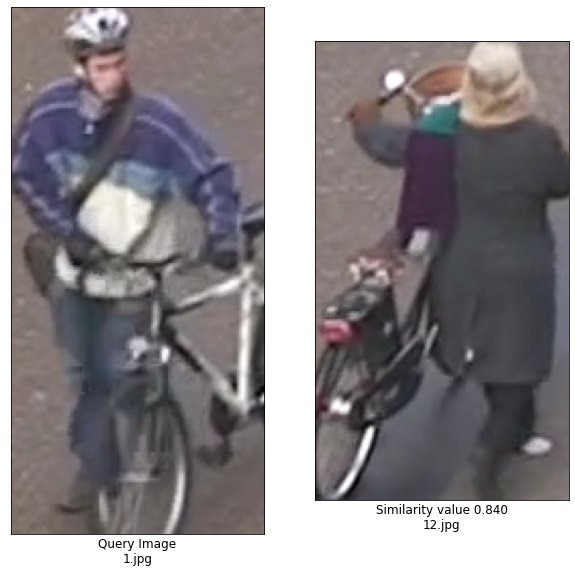

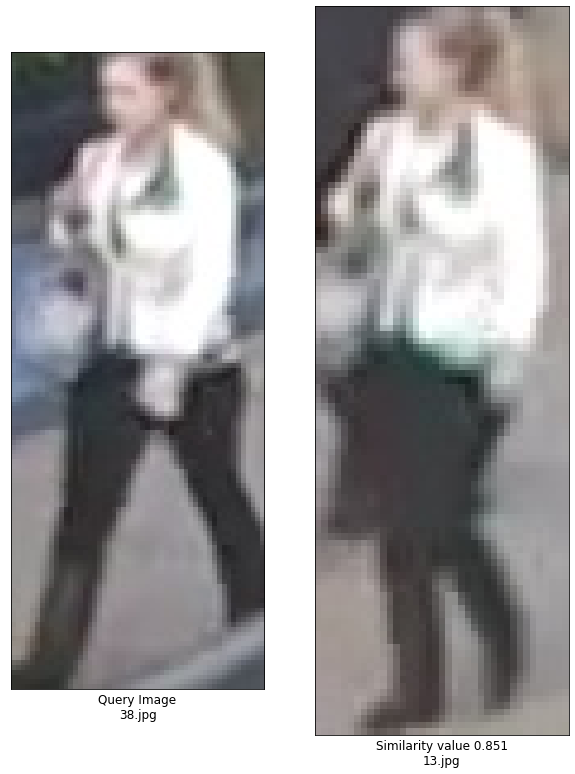

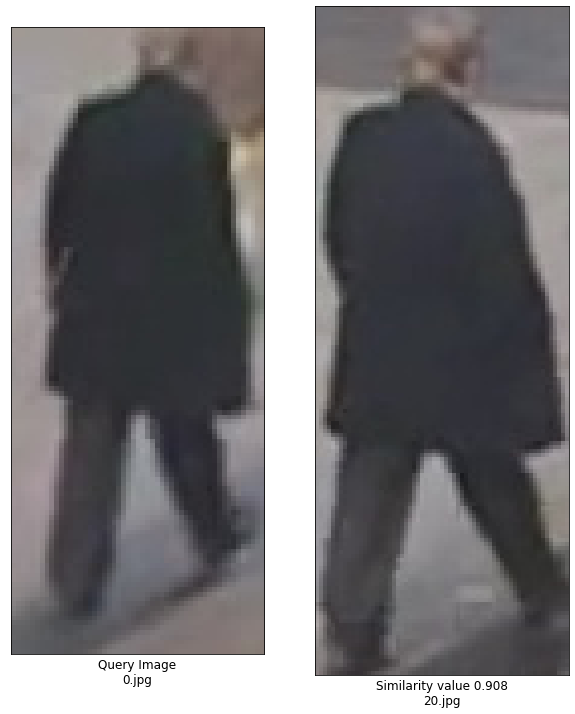

In [40]:
import matplotlib.pyplot as plt
    
# take three examples from the provided image set and plot
inputImages = ["1.jpg", "38.jpg", "0.jpg"]

numCol = 2
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 3)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(10, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            if simValues[j-1]>0.80:
              img = Image.open(os.path.join(inputDir, simImages[j-1]))
              ax.append(fig.add_subplot(numRow, numCol, j+1))
              setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
            else:
              print("Could not find matching image for the below Query Image")
              continue
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)